# The way I discovered GPU computations with python
This notebook shows my first steps with GPU computations. It explains my motivations and presents all the steps I went through before I programmed my best performing, parallelized function. The end result was really astounding, since with a budget nvidia card I was able to solve my **real scientific problem** the whole **orders of magnitude faster** than on a decent cpu.
## Why should I care?
There are many situations where fast computing is essential and there are many solultions too. Here is my case: I'm a PhD student and I need to solve many initial value ODE problems in a kind of Monte Carlo simulation. When I finally wrote my c++ program and gave it desired input it turned out that the simulation would run 2 months. Oops. Back then, I reduced the number of samples so that it finished in a couple of days, but at the cost of quality.
Long story short, one day I've heard that my problem was a perfect task for a GPU. A graphic card is able to solve thousends of similar simple tasks in parallel, they said. I even saw an appealing YouTube video:

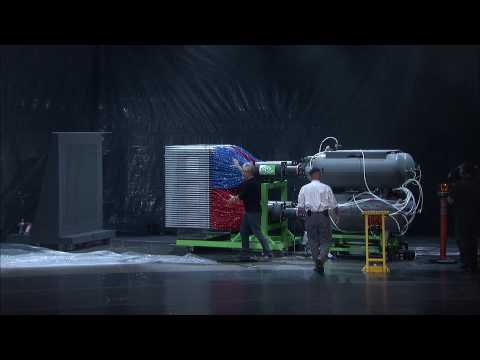

In [2]:
from IPython.display import YouTubeVideo

YouTubeVideo('-P28LKWTzrI', width=600, height=300)

It looked to me like they exagerate a bit. If this GPU stuff is so cool, why isn't it well known to all the researchers around? It turned out that it's not exagerated at all and also quite easy to program. Let's see how it works.

## Test case
For the purpose of this tutorial we'll compute and draw a Poincare Map of chaotic Duffing oscillator. Without getting into non-programming details, we'd have to solve the following ordinary differential equation as many times as possible in a given time period.
$$
dxdt_0 = x_1
$$ $$
dxdt_1 = 10sin(t)-0.1x_1-x_0^3
$$
We treat it as an initial value problem and solve with various random initial conditions. At the end we plot the state of each solution in a common $x_0, x_1$ plane. The result should look like somewhat like this:

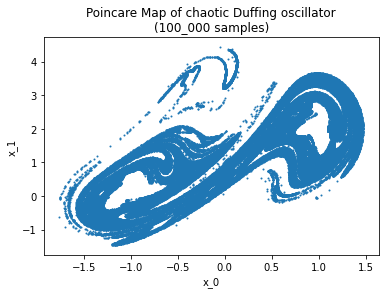

In [3]:
from IPython.display import Image
Image("Fig1_map.png")

Note that this isn't the standard way of plotting a Poincare Map. I made a few assumptions and I'd be glad to explain them if anyone asks :)  
Regarding the simulations, we assume the following (found by trial and error):

* time of single simulation: **t_end = 100**  
* time step: **dt = 0.01**  
* solver: **Euler method** (https://en.wikipedia.org/wiki/Euler_method)  
* initial conditions range: **between 0 and 1**
* real time for siulation: **10 [s]**

So here is the simplest python implementation I could think of, that would produce the result above:

Wall time: 9.94 s


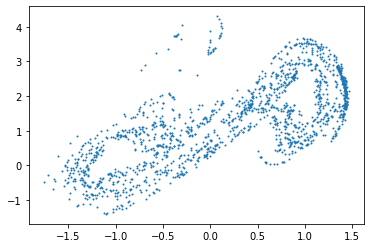

In [22]:
import random
import math
import matplotlib.pyplot as plt


def simple_approach(samples):
    # create empty lists for results
    result_x0 = []
    result_x1 = []
    
    # specify time parameters
    dt = 0.01
    t_end = 100
    
    # repeat appropriate number of times
    for i in range(samples):
        # set starting time
        t = 0
        
        #draw initial conditions
        x0 = random.random()
        x1 = random.random()
        
        # simulate
        while t < t_end:
            # compute derivatives
            dxdt0 = x1
            dxdt1 = 10*math.sin(t) - 0.1*x1 - x0**3
            
            # update state vector
            x0 += dxdt0 * dt
            x1 += dxdt1 * dt
            
            # update time
            t += dt
        
        # append results
        result_x0.append(x0)
        result_x1.append(x1)
    
    return result_x0, result_x1

# nr of simulations to fit within 10s
samples = 1600

# run function and time it
%time r_x0, r_x1 = simple_approach(samples)

# plot results
plt.scatter(r_x0, r_x1, s=1)
        

As you can see, I was able to get around 1600 points within my time limit of 10 seconds. This isn't quite enough, but we can do much better, even without pallalelizm.

## How about precompiling the code?
Now this seems really riddiculous to me, but it is possible to make the same code more then **56 times** faster by only adding **two lines of code**. There is a python package called numba that precompiles the code making it virtually as fast as if it was written in c. Amazing.

Wall time: 10 s


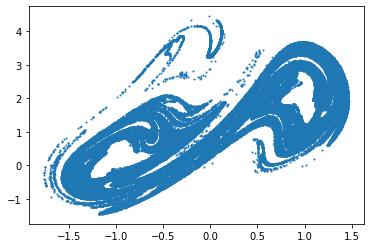

In [29]:
import random
import math
import matplotlib.pyplot as plt
import numba


@numba.jit
def precompiled_approach(samples):
    # create empty lists for results
    result_x0 = []
    result_x1 = []
    
    # specify time parameters
    dt = 0.01
    t_end = 100
    
    # repeat appropriate number of times
    for i in range(samples):
        # set starting time
        t = 0
        
        #draw initial conditions
        x0 = random.random()
        x1 = random.random()
        
        # simulate
        while t < t_end:
            # compute derivatives
            dxdt0 = x1
            dxdt1 = 10*math.sin(t) - 0.1*x1 - x0**3
            
            # update state vector
            x0 += dxdt0 * dt
            x1 += dxdt1 * dt
            
            # update time
            t += dt
        
        # append results
        result_x0.append(x0)
        result_x1.append(x1)
    
    return result_x0, result_x1

# nr of simulations to fit within 10s
samples = 90_000

# run function and time it
%time r_x0, r_x1 = precompiled_approach(samples)

# plot results
plt.scatter(r_x0, r_x1, s=1)


Of course not every piece of code can be compiled this way, but as long as you keep it simple, the compilation is pretty straight forward. By this time, we've probabely cracked the test case completly, as the graph won't get any better with more samples. Nevertheless, let's try to optimize further.

## Multiprocessing
Almost all modern computers have multiple cores in their CPUs. As each simulation is completly independend from all the others, let's try to run them on multiple cores in parallel.

Wall time: 3.06 s


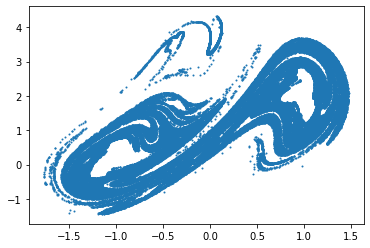

In [22]:
import random
import math
import matplotlib.pyplot as plt
import numba
import numpy as np


@numba.jit(parallel=True)
def precompiled_parallel_approach(samples):
    # create empty lists for results
    result_x0 = np.zeros(samples)
    result_x1 = np.zeros(samples)
    
    # specify time parameters
    dt = 0.01
    t_end = 100
    
    # repeat appropriate number of times
    for i in numba.prange(samples):
        # set starting time
        t = 0
        
        #draw initial conditions
        x0 = random.random()
        x1 = random.random()
        
        # simulate
        while t < t_end:
            # compute derivatives
            dxdt0 = x1
            dxdt1 = 10*math.sin(t) - 0.1*x1 - x0**3
            
            # update state vector
            x0 += dxdt0 * dt
            x1 += dxdt1 * dt
            
            # update time
            t += dt
        
        # append results
        result_x0[i] = x0
        result_x1[i] = x1
    
    return result_x0, result_x1

# nr of simulations to fit within 10s
samples = 90_000

# run function and time it
%time r_x0, r_x1 = precompiled_parallel_approach(samples)

# plot results
plt.scatter(r_x0, r_x1, s=1)

Can you see that? I have i5-4570 in my pc, they say it has 4 cores/4 threads, and we achieved another **4 fold speed-up** with only some tiny modifications.
* First of all, I've add a parallel=True argument to the decorator.
* Then, the return arrays were preallocated in order to make each thread write into separate place in memory; for this purpose I used numpy package. Note that for some reason a normal python list created with list comprehension wouldn't work, and I'm not sure why.
* Lastly, range() was replaced by numba.prange() in order to indicate which part of code can by parallelized.

Look how numba took care of all cpu core handling in the background. Could it be any simpler?

## Can we get any better with GPU?
Here is the deal. GPU can handle thousands of parallel processes instead of four. On the other hand each of them is in general slower then on CPU. Let's see how this works out at the end. For testing purposes I've bought a low-end nvidia card GT 710. I didn't have much choice on the model with the following requirements:
* Low profile (for my small pc box)
* Low cost (for I'm a student)
* CUDA technology on the board (to take advantage of GPU parallelism with little programming efford)

Wall time: 730 ms


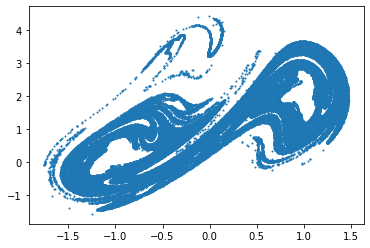

In [23]:
import math
import matplotlib.pyplot as plt
from numba import cuda
import numpy as np


@cuda.jit
def cuda_approach(x):
    # specify time parameters
    t = np.float32(0)
    dt = np.float32(0.01)
    t_end = np.float32(100)
    
    # specify thread on the GPU
    th = cuda.grid(1)
    pos = th * 2
    
    # repeat for each thread
    if pos < x.size-1:

        # simulate
        while t < t_end:
            # compute derivatives
            dxdt0 = x[pos + 1]
            dxdt1 = np.float32(10.0)*math.sin(t) - np.float32(0.1)*x[pos + 1] - x[pos]**3
            
            # update state vector
            x[pos] += dxdt0 * dt
            x[pos + 1] += dxdt1 * dt
            
            # update time
            t += dt
        

# nr of simulations to fit within 10s
samples = 90_000

# preallocation
x = np.random.random_sample(samples * 2).astype('float32')

# run function and time it
th_per_block = 32 * 4
bl_per_grid = samples // th_per_block + 1

%time cuda_approach[bl_per_grid, th_per_block](x)

x = x.reshape((samples, 2))

# plot results
plt.scatter(x[:, 0], x[:, 1], s=1)

Now have a look at this. The program executed roughly 4 times faster than the precompiled multicore CPU version.
In turn, quite a lot of things had changed in the code.

First, we decorate the function with `@cuda.jit` instead of `@jit` alone. Without too much details, CUDA is a technology developed by Nvidia that facilitates GPU programming. In order to use it on your pc you need a compatible graphics card and cuda toolkit installed.

Next thing that strikes a bit is 'float32' spread all over the code. As far as I understand it, most of the today's GPUs prefer 32 bit numbers for computations, whereas modern CPUs tend to use 64 bits. Therefore one must explicitly tell the compiler, that the precision we need is 32, otherwise it will default to 64 and it must be done on every number used in the code.

Also prallelism is handled in a different way since we tend to use as many threads as there are simulations to be done (in our case 90'000). Each thread has it's unique id obtained from `cuda.grid(1)`. Then, it looks like each thread enters the function and executes it on it's own part of array, which is done by indexing the array with the number of thread. By the way it is possible to use multidimensional arrays, but I leave it to the reader. I'm also not getting into the details of thread handling as it is well described in numba documentation (https://numba.pydata.org/numba-doc/latest/cuda/index.html).

The last big difference is that the function has no return value. Instead, it writes to the input array as if it was only a reference (c-style).

## Summary
I'm not sure about you, but I honestly think it's all really impressive. People tend to make distinctions like "Python is simple and slow, while c is difficult an fast". This used to be true, but it seems like the rules are changing. Look how much easier it is to use `numba.jit` decorator and keep all Python syntax rather then develop piece of code in c. Also GPU computations are at our fingertips with CUDA, even though the new bits of syntax may seem overhelming at first glance.
Anyway if you are new to the subject I hope that you found my tutorial at least somewhat interesting. On the other hand, if you are experienced, I hope I wasn't too inacurate in my descriptions (any feedback is welcome :) ).

I wish you all the best and see you next time!

Konrad